In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./test_score.ipynb'))))

import numpy as np
import pandas as pd

from ylearn.estimator_model.causal_forest import CausalForest
from ylearn.estimator_model._generalized_forest._grf import GRForest
from ylearn.exp_dataset.exp_data import sq_data
from ylearn.utils._common import to_df
from ylearn.estimator_model._naive_forest.utils import grad, grad_coef, inverse_grad

from numpy.linalg import lstsq, inv

from copy import deepcopy


n = 2000
d = 10     
n_x = 1
y, x, v = sq_data(n, d, n_x)

true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_x - 1))])
w = deepcopy(v)
v_test = v[:min(100, n)].copy()
v_test[:, 0] = np.linspace(np.percentile(v[:, 0], 1), np.percentile(v[:, 0], 99), min(100, n))
data = to_df(treatment=x, outcome=y, v=v)
test_data = to_df(v=v_test)

outcome = 'outcome'
treatment = 'treatment'
adjustment = data.columns[2:]
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
# x = oh.fit_transform(x).toarray().astype(np.float32)

In [2]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

cf = CausalForest(
    # x_model=RandomForestClassifier(),
    x_model=RandomForestRegressor(),
    y_model=RandomForestRegressor(),
    cf_fold=1,
    is_discrete_treatment=False,
    n_jobs=1,
    n_estimators=100,
    random_state=1,
    min_impurity_decrease=1e-8,
    max_depth=10,
    max_leaf_nodes=100,
    verbose=0
)

In [3]:
cf.fit(data=data, outcome=outcome, treatment=treatment, adjustment=None, covariate=adjustment)

10-09 17:48:06 I ylearn.e.double_ml.py 735 - _fit_1st_stage: fitting x_model RandomForestRegressor
10-09 17:48:07 I ylearn.e.double_ml.py 740 - _fit_1st_stage: fitting y_model RandomForestRegressor


CausalForest(x_model=RandomForestRegressor(), y_model=RandomForestRegressor(), n_estimators=None, min_samples_split=None, min_samples_leaf=None, min_weight_fraction_leaf=None, max_features=None, min_impurity_decrease=None, random_state=1, ccp_alpha=None, is_discrete_treatment=False, verbose=None, warm_start=None)

In [4]:
# x_dis = cf.comp_transormer(x)

# x_cf =  x_dis - (cf.x_hat_dict['paras'][0])
# y_cf = y.reshape(-1, 1) - cf.y_hat_dict['paras'][0].reshape(-1, 1)

In [5]:
# cfff = GRForest(max_depth=100, max_leaf_nodes=100, verbose=0)
# cfff._fit_with_array(y_cf, x_cf, w, v, sample_weight=None)

In [6]:
# cfff.covariate = adjustment

In [7]:

# effect__ = cfff._prepare4est(data=test_data)
# effect__

In [8]:
effect = cf.estimate(test_data)

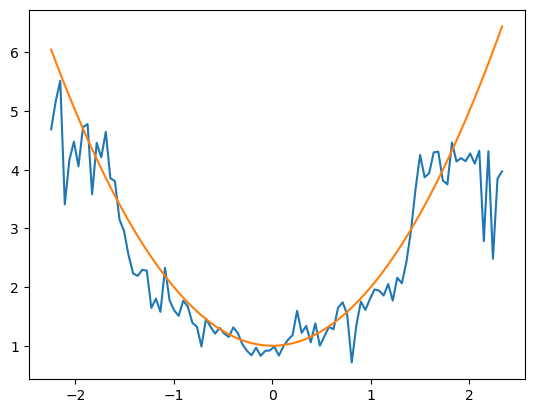

In [9]:
import matplotlib.pyplot as plt

true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_x - 1))])

for t in range(n_x):
    plt.plot(v_test[:, 0], effect[:, t])
    plt.plot(v_test[:, 0], true_te(v_test)[:, t])
plt.show()

In [10]:
from numpy.linalg import lstsq